In [41]:
import os
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid

In [42]:
def process_power_per_pod(folder_path):
    # Process power consumption data
    power_file = os.path.join(folder_path, "metrics_energy.json")
    uid_pod_map_file = os.path.join(folder_path, "uid_pod_mapping.csv")  # Now reading as a CSV

    # Load UID to Pod Name Mapping
    if os.path.exists(uid_pod_map_file):
        uid_pod_map = pd.read_csv(uid_pod_map_file)  # Read CSV into a DataFrame
        # Ensure the mapping DataFrame has expected columns
        if not {"UID", "Pod Name"}.issubset(uid_pod_map.columns):
            print("Invalid UID-Pod mapping format")
            return pd.DataFrame()  # Return an empty DataFrame
    else:
        print("No UID-Pod mapping file found")
        return pd.DataFrame()  # Return an empty DataFrame

    # Load Power Data
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
    else:
        print("No power data file found")
        return pd.DataFrame()  # Return an empty DataFrame
       
    # Collect timestamps and values for all pods
    rows = []
    for uid_suffix, data in power_data.items():
        # Map UID suffix to pod name using the DataFrame
        pod_name_row = uid_pod_map[uid_pod_map["UID"].str.endswith(uid_suffix)]
        if pod_name_row.empty:
            continue  # Skip if no matching UID is found
        pod_name = pod_name_row.iloc[0]["Pod Name"]  # Get the first match

        # Append each entry in the pod's power data to the rows list
        for entry in data:
            rows.append({
                "timestamp": entry["timestamp"],
                "pod_name": pod_name,
                "value": entry["value"]
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)

    return df


In [43]:
def process_folder(folder_path):
    # Extract configuration from folder name
    folder_name = os.path.basename(folder_path)
    requested_mbps, duration, packet_length = folder_name.split('_')
    duration = int(duration)

    # Initialize results
    avg_mbps_received = 0  # Default if no files found

    # Process iperf server log
    server_files = glob.glob(os.path.join(folder_path, "log_iperf_server_*.csv"))
    if server_files:
        total_mbps_sum = 0  # Initialize total sum
        for server_file in server_files:
            df_server = pd.read_csv(server_file)
            df_server['Mbps'] = df_server['Bitrate'] / 1e6  # Convert bps to Mbps
            total_mbps_sum += df_server['Mbps'].mean()  # Add mean Mbps for this file to the total sum
        
        avg_mbps_received = total_mbps_sum

    # Process pod-level power data using process_power_per_pod
    df_pod_power = process_power_per_pod(folder_path)

    # Initialize aggregated power and energy consumption variables
    power_components = ['oai-cu', 'oai-du', 'oai-nr-ue', 'oai-upf']
    power_results = {component: {'baseline': 0, 'experiment': 0} for component in power_components}
    energy_results = {component: {'baseline': 0, 'experiment': 0} for component in power_components}

    # Aggregate power and energy consumption per component
    for component in power_components:
        component_pods = df_pod_power[df_pod_power["pod_name"].str.startswith(component)]
        if not component_pods.empty:
            component_pods_sorted = component_pods.sort_values(by="timestamp")
            baseline_filtered = component_pods_sorted.iloc[50:100]
            experiment_filtered = component_pods_sorted.iloc[-duration :] #+ 10

            # Calculate baseline and experiment power averages
            power_results[component]['baseline'] = baseline_filtered['value'].mean()
            power_results[component]['experiment'] = experiment_filtered['value'].mean()

            # Calculate energy as the integral of power over time (assuming equal time intervals)
            baseline_energy = trapezoid(baseline_filtered['value'], dx=1)
            experiment_energy = trapezoid(experiment_filtered['value'], dx=1)
            energy_results[component]['baseline'] = baseline_energy
            energy_results[component]['experiment'] = experiment_energy

    # Combine CPU usage (if applicable) for each component
    cpu_usages = {}
    cpu_file = os.path.join(folder_path, "metrics_cpu.json")
    if os.path.exists(cpu_file):
        with open(cpu_file, 'r') as f:
            cpu_data = json.load(f)
        
        # Aggregate CPU usage per component
        for pod_name, pod_data in cpu_data.items():
            component = next((comp for comp in power_components if pod_name.startswith(comp)), None)
            if component:
                cpu_usages.setdefault(component, [])
                for entry in pod_data:
                    cpu_usages[component].append(entry['value'])

    avg_cpu_usage = {comp: (sum(values) / len(values) if values else 0) for comp, values in cpu_usages.items()}

    # Combine the results into a single row for baseline and experiment
    baseline = {
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "duration": int(duration),
        "avg Mbps effectively received at server": avg_mbps_received,
    }
    experiment = {
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "duration": int(duration),
        "avg Mbps effectively received at server": avg_mbps_received,
    }

    # Add power, energy, and CPU consumption data to baseline and experiment
    for component in power_components:
        # Add power consumption data
        baseline[f"avg {component.upper()} power consumption [W]"] = power_results[component]['baseline']
        experiment[f"avg {component.upper()} power consumption [W]"] = power_results[component]['experiment']

        # Add energy consumption data
        baseline[f"total {component.upper()} energy consumption [J]"] = energy_results[component]['baseline']
        experiment[f"total {component.upper()} energy consumption [J]"] = energy_results[component]['experiment']

        # Add CPU usage data, if available
        if component in avg_cpu_usage:
            baseline[f"avg {component.upper()} CPU usage [%]"] = avg_cpu_usage[component]
            experiment[f"avg {component.upper()} CPU usage [%]"] = avg_cpu_usage[component]

    return baseline, experiment


In [ ]:

def gather_metrics(base_folder_path):
    data_baseline = []
    data_experiment = []

    # Iterate through all pools of experiments in the base folder
    for experiment_pool in os.listdir(base_folder_path):
        pool_path = os.path.join(base_folder_path, experiment_pool)
        
        # Check if the pool path is a directory
        if not os.path.isdir(pool_path):
            continue

        # Process each folder inside the pool
        for subfolder in os.listdir(pool_path):
            folder_path = os.path.join(pool_path, subfolder)
            if os.path.isdir(folder_path):  # Check if it's a directory
                # Process the folder and get baseline and experiment data
                baseline, experiment = process_folder(folder_path)
                
                # Append baseline and experiment data to their respective lists
                data_baseline.append(baseline)
                data_experiment.append(experiment)

    # Combine baseline and experiment data into DataFrames
    df_baseline = pd.DataFrame(data_baseline)
    df_experiment = pd.DataFrame(data_experiment)

    # Calculate mean and std for baseline and experiment metrics
    baseline_stats = df_baseline.agg(['mean', 'std']).T if not df_baseline.empty else pd.DataFrame()
    experiment_stats = df_experiment.agg(['mean', 'std']).T if not df_experiment.empty else pd.DataFrame()

    return df_baseline, df_experiment, baseline_stats, experiment_stats

# Example usage
base_folder_path = "/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/packet_energy/"

df_baseline, df_experiment, baseline_stats, experiment_stats = gather_metrics(
    base_folder_path
)
df_experiment = df_experiment[df_experiment['packet length requested'].isin([300])]


In [45]:
df_experiment

,Mbps requested,packet length requested,duration,avg Mbps effectively received at server,avg OAI-CU power consumption [W],total OAI-CU energy consumption [J],avg OAI-DU power consumption [W],total OAI-DU energy consumption [J],avg OAI-NR-UE power consumption [W],total OAI-NR-UE energy consumption [J],avg OAI-UPF power consumption [W],total OAI-UPF energy consumption [J]
3,20,300,100,20.971480,0.079214,7.874340,0.495721,49.046455,0.698805,69.137652,0.185261,18.416748
5,90,300,100,61.115921,0.267035,26.537428,0.483708,47.835881,1.225715,121.244247,0.585160,58.163658
6,30,300,100,31.446276,0.111108,11.048232,0.558085,55.252029,0.866174,85.753431,0.260602,25.909861
8,100,300,100,61.026081,0.297396,29.563435,0.511971,50.704895,1.217924,120.627888,0.631110,62.744353
19,70,300,100,71.887473,0.209148,20.792712,0.593947,58.804895,1.248315,123.585018,0.470559,46.777433
23,60,300,100,61.820395,0.178052,17.703669,0.560640,55.508140,1.117159,110.598315,0.405714,40.335181
30,10,300,100,10.485870,0.049373,4.910029,0.512034,50.698914,0.627132,62.097344,0.110715,11.009000
31,80,300,100,56.781407,0.250673,24.920052,0.486149,48.134732,1.145996,113.452792,0.548629,54.533360
38,50,300,100,52.185563,0.167990,16.700439,0.585007,57.922650,1.096004,108.510389,0.380725,37.848764
44,40,300,100,41.895602,0.130569,12.984644,0.557713,55.228409,0.964899,95.545572,0.308818,30.707863


In [46]:
def calculate_per_throughput_energy(df_baseline, df_experiment):
    # Compute the differences between experiment and baseline metrics
    df_diff = df_experiment.copy()
    # Drop rows containing any NaN values
    df_diff = df_diff.dropna()
    df_baseline = df_baseline.dropna()

    # Compute the differences for each power component
    # df_diff['total OAI-DU energy consumption [J]'] -= df_baseline['total OAI-DU energy consumption [J]']

    # Filter out rows with negative power consumption values in any component
    df_diff = df_diff[
        (df_diff['avg OAI-DU power consumption [W]'] >= 0) &
        (df_diff['avg OAI-CU power consumption [W]'] >= 0) &
        (df_diff['avg OAI-UPF power consumption [W]'] >= 0)
    ]

    # Calculate the total power of the service for the experiment
    df_diff["total power service [W]"] = (
        df_diff['avg OAI-DU power consumption [W]'] +
        df_diff['avg OAI-CU power consumption [W]'] +
        df_diff['avg OAI-UPF power consumption [W]']
    )

    # Calculate the total energy consumed by the service (in Joules)
    df_diff["total energy service [J]"] = (
        df_diff['total OAI-DU energy consumption [J]'] +
        df_diff['total OAI-CU energy consumption [J]'] +
        df_diff['total OAI-UPF energy consumption [J]']
    )

    # Calculate the total number of packets
    df_diff['N packets'] = (
        df_diff['avg Mbps effectively received at server'] * 1e6 /
        (df_diff['packet length requested'] )  # Convert bytes to bits
    ) * df_diff['duration']  # Multiply by duration (in seconds)


    # Calculate energy per single packet (in Joules per packet)
    df_diff['energy x packet [J/packet]'] = (
        df_diff["total energy service [J]"] / df_diff['N packets']
    )

    # Calculate power per packet (in Watts per packet, optional)
    df_diff['power x packet [W/packet]'] = (
        df_diff["total power service [W]"] / df_diff['N packets']
    )

    # Group by throughput and compute mean and std for relevant metrics
    per_throughput_stats = df_diff.groupby('Mbps requested').agg(
        {
            'avg Mbps effectively received at server': ['mean', 'std'],
            'packet length requested': ['mean', 'std'],
            'duration': ['mean', 'std'],
            'total OAI-DU energy consumption [J]': ['mean', 'std'],
            'total OAI-CU energy consumption [J]': ['mean', 'std'],
            'total OAI-UPF energy consumption [J]': ['mean', 'std'],
            'avg OAI-DU power consumption [W]': ['mean', 'std'],
            'avg OAI-CU power consumption [W]': ['mean', 'std'],
            'avg OAI-UPF power consumption [W]': ['mean', 'std'],
            'total power service [W]': ['mean', 'std'],
            'total energy service [J]': ['mean', 'std'],  # Total energy
            'N packets': ['mean', 'std'],
            'energy x packet [J/packet]': ['mean', 'std'],  # Energy per packet
            'power x packet [W/packet]': ['mean', 'std'],  # Power per packet
        }
    ).reset_index()

    return df_diff, per_throughput_stats

# Calculate energy metrics and per-throughput stats
df_energy_x_packet, per_throughput_stats = calculate_per_throughput_energy(df_baseline, df_experiment)

# Display aggregated stats per throughput
print("\nAggregated Stats Per Throughput (Mean and Std):")
per_throughput_stats.columns



Aggregated Stats Per Throughput (Mean and Std):


MultiIndex([(                         'Mbps requested',     ''),
            ('avg Mbps effectively received at server', 'mean'),
            ('avg Mbps effectively received at server',  'std'),
            (                'packet length requested', 'mean'),
            (                'packet length requested',  'std'),
            (                               'duration', 'mean'),
            (                               'duration',  'std'),
            (    'total OAI-DU energy consumption [J]', 'mean'),
            (    'total OAI-DU energy consumption [J]',  'std'),
            (    'total OAI-CU energy consumption [J]', 'mean'),
            (    'total OAI-CU energy consumption [J]',  'std'),
            (   'total OAI-UPF energy consumption [J]', 'mean'),
            (   'total OAI-UPF energy consumption [J]',  'std'),
            (       'avg OAI-DU power consumption [W]', 'mean'),
            (       'avg OAI-DU power consumption [W]',  'std'),
            (       'avg 

# Energy x packet over Duration, different rate, same number of packets sent

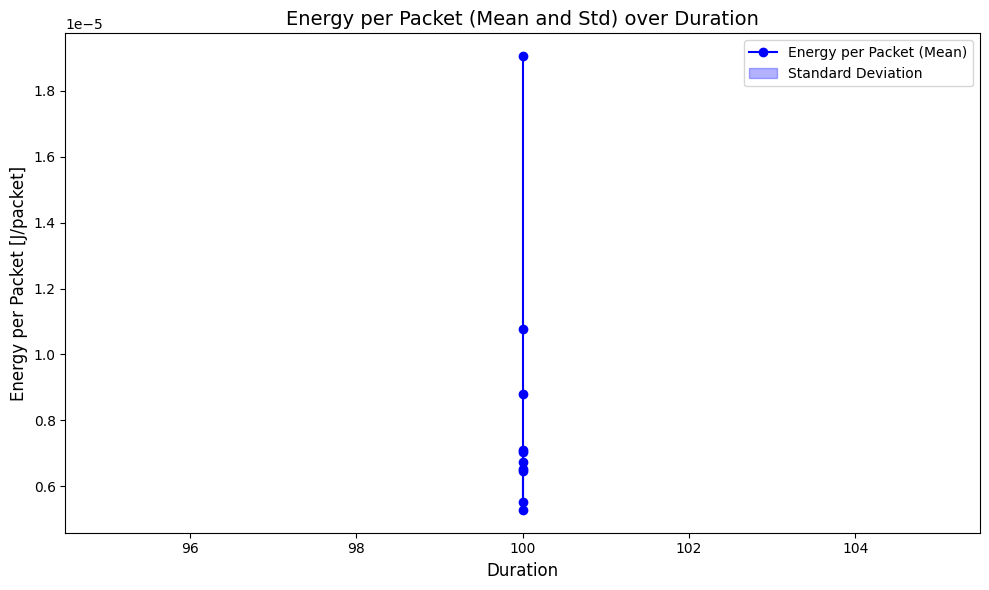

In [47]:
# Extract energy per packet mean and std from the per_throughput_stats DataFrame
energy_per_packet_mean = per_throughput_stats[('energy x packet [J/packet]', 'mean')]
energy_per_packet_std = per_throughput_stats[('energy x packet [J/packet]', 'std')]
throughput = per_throughput_stats[('duration','mean')]

# Plot the energy per packet (mean) with standard deviation
plt.figure(figsize=(10, 6))

# Plot the energy per packet mean
plt.plot(throughput, energy_per_packet_mean, label='Energy per Packet (Mean)', color='blue', marker='o')

# Add shaded area for standard deviation
plt.fill_between(throughput, 
                 energy_per_packet_mean - energy_per_packet_std, 
                 energy_per_packet_mean + energy_per_packet_std, 
                 color='blue', alpha=0.3, label='Standard Deviation')

# Add labels and title
plt.title('Energy per Packet (Mean and Std) over Duration', fontsize=14)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Energy per Packet [J/packet]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


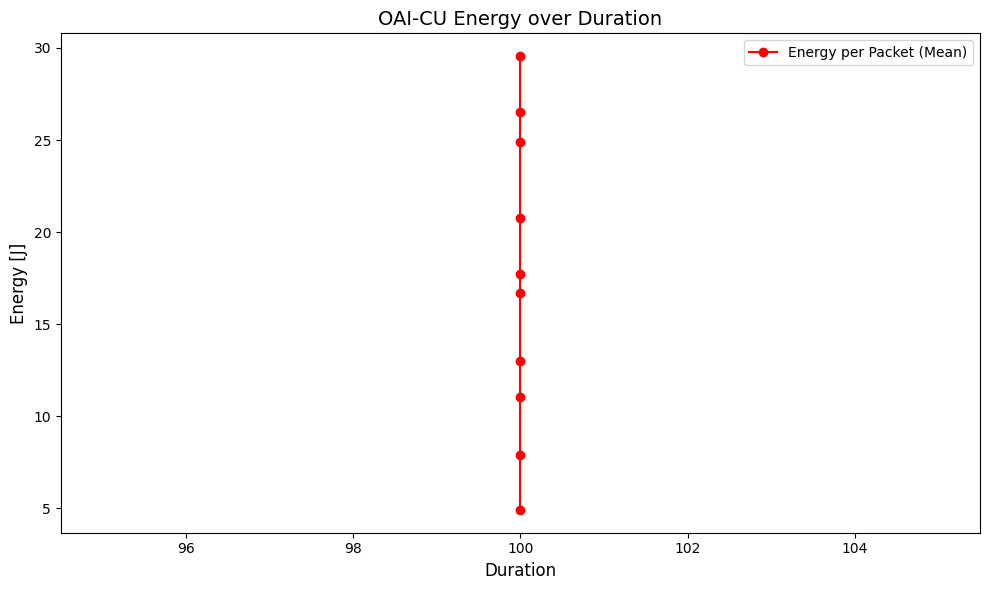

In [48]:
# Extract energy per packet mean and std from the per_throughput_stats DataFrame


energy_per_packet_cu = per_throughput_stats[('total OAI-CU energy consumption [J]', 'mean')]
# energy_per_packet_std = per_throughput_stats[('total OAI-CU energy consumption [J]', 'std')]
throughput = per_throughput_stats[('duration','mean')]

# Plot the energy per packet (mean) with standard deviation
plt.figure(figsize=(10, 6))

# Plot the energy per packet mean
plt.plot(throughput, energy_per_packet_cu, label='Energy per Packet (Mean)', color='red', marker='o')

# Add shaded area for standard deviation
# plt.fill_between(throughput, 
#                  energy_per_packet_mean - energy_per_packet_std, 
#                  energy_per_packet_mean + energy_per_packet_std, 
#                  color='blue', alpha=0.3, label='Standard Deviation')

# Add labels and title
plt.title('OAI-CU Energy over Duration', fontsize=14)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Energy [J]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


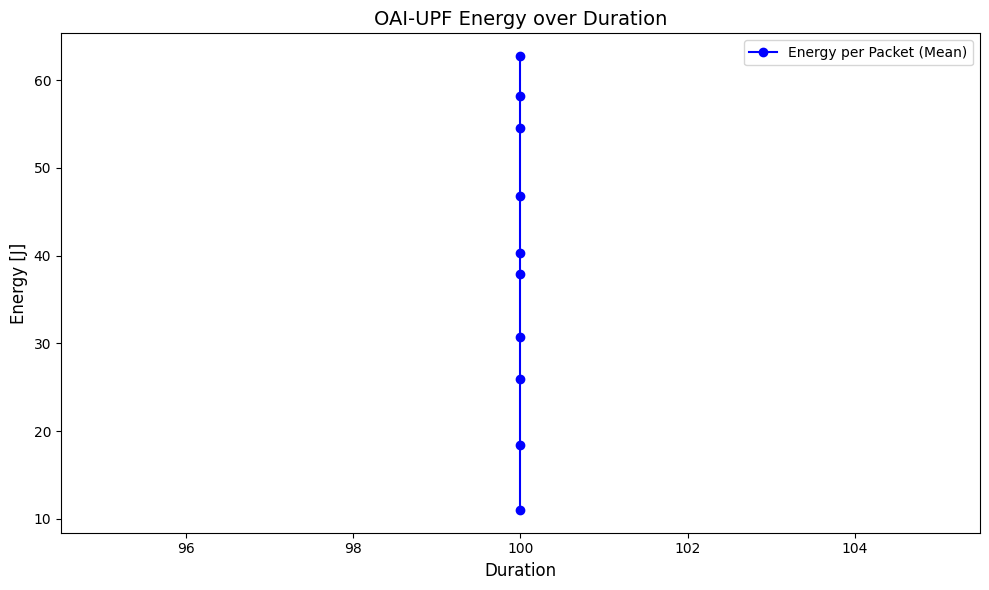

In [49]:
# Extract energy per packet mean and std from the per_throughput_stats DataFrame


energy_per_packet_cu = per_throughput_stats[('total OAI-UPF energy consumption [J]', 'mean')]
# energy_per_packet_std = per_throughput_stats[('total OAI-UPF energy consumption [J]', 'std')]
throughput = per_throughput_stats[('duration','mean')]

# Plot the energy per packet (mean) with standard deviation
plt.figure(figsize=(10, 6))

# Plot the energy per packet mean
plt.plot(throughput, energy_per_packet_cu, label='Energy per Packet (Mean)', color='blue', marker='o')

# Add shaded area for standard deviation
# plt.fill_between(throughput, 
#                  energy_per_packet_mean - energy_per_packet_std, 
#                  energy_per_packet_mean + energy_per_packet_std, 
#                  color='blue', alpha=0.3, label='Standard Deviation')

# Add labels and title
plt.title('OAI-UPF Energy over Duration', fontsize=14)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Energy [J]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


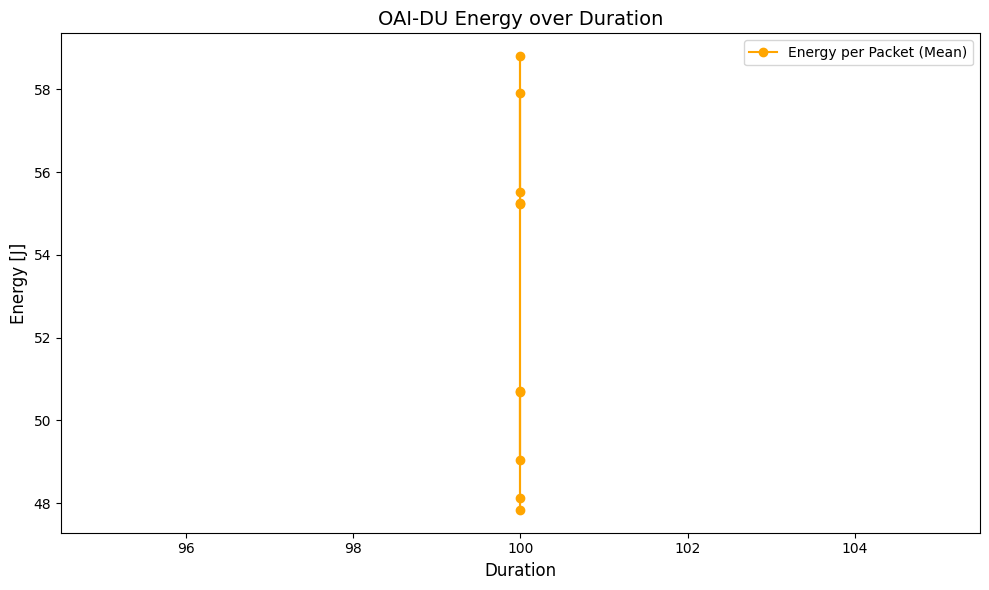

In [50]:
# Extract energy per packet mean and std from the per_throughput_stats DataFrame


energy_per_packet_cu = per_throughput_stats[('total OAI-DU energy consumption [J]', 'mean')]
# energy_per_packet_std = per_throughput_stats[('total OAI-DU energy consumption [J]', 'std')]
throughput = per_throughput_stats[('duration','mean')]

# Plot the energy per packet (mean) with standard deviation
plt.figure(figsize=(10, 6))

# Plot the energy per packet mean
plt.plot(throughput, energy_per_packet_cu, label='Energy per Packet (Mean)', color='orange', marker='o')

# Add shaded area for standard deviation
# plt.fill_between(throughput, 
#                  energy_per_packet_mean - energy_per_packet_std, 
#                  energy_per_packet_mean + energy_per_packet_std, 
#                  color='orange', alpha=0.3, label='Standard Deviation')

# Add labels and title
plt.title('OAI-DU Energy over Duration', fontsize=14)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Energy [J]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Percentage of each component

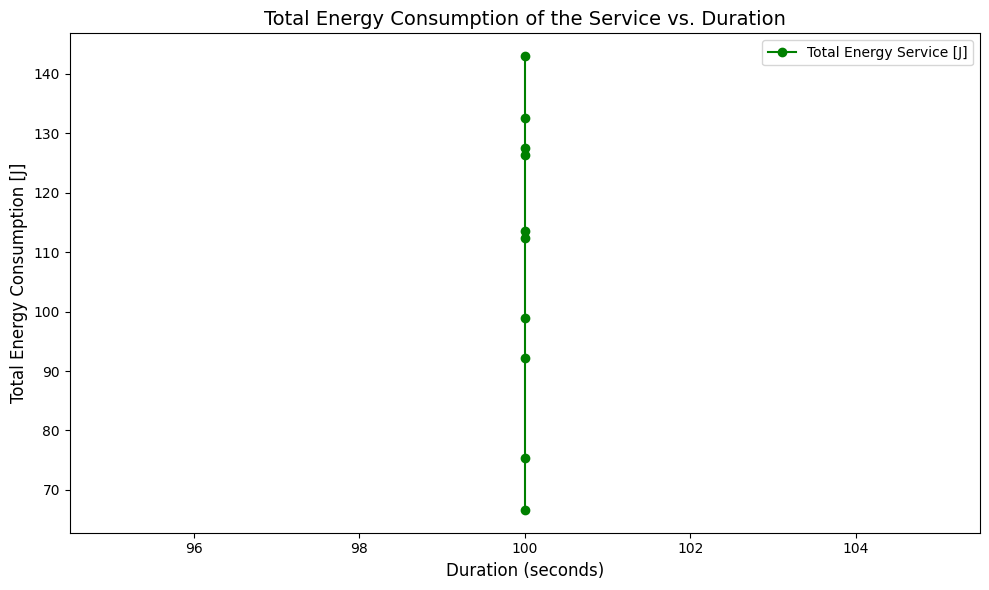

In [51]:
import matplotlib.pyplot as plt

# Extract the necessary columns from the MultiIndex dataframe
# We focus on the 'mean' values of the total energy consumption for each component
duration = per_throughput_stats[('duration', 'mean')]

# Calculate the total energy service as the sum of all components' energy consumption
total_energy_service = per_throughput_stats[('total energy service [J]', 'mean')]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(duration, total_energy_service, label='Total Energy Service [J]', color='green', marker='o')

# Adding labels and title
plt.title('Total Energy Consumption of the Service vs. Duration', fontsize=14)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Total Energy Consumption [J]', fontsize=12)

# Display legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Energy efficiency

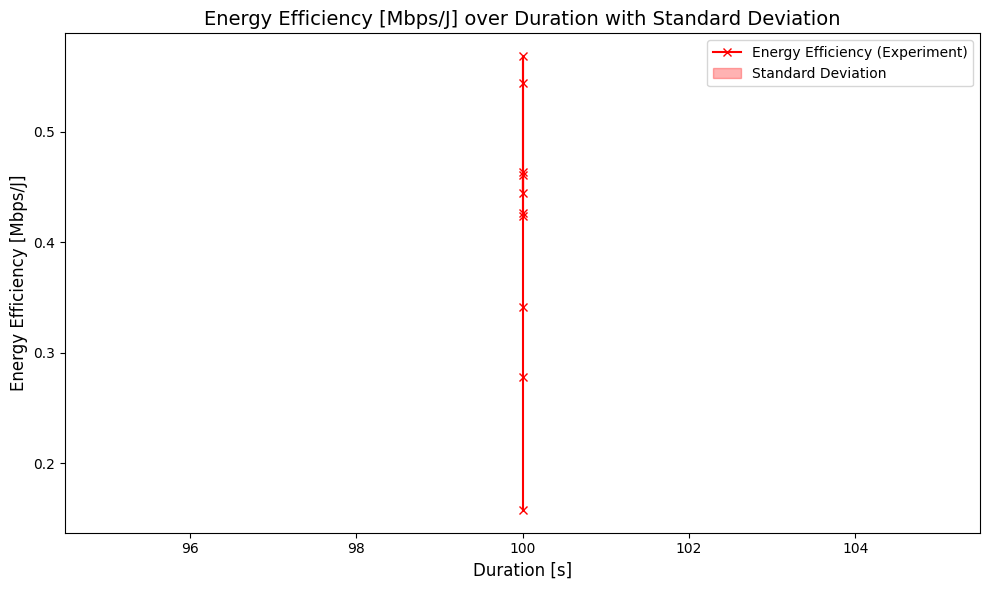

In [52]:
import matplotlib.pyplot as plt

# Filter the data to only include rows where 'N packets' > 0
filtered_stats = per_throughput_stats[per_throughput_stats[('N packets', 'mean')] > 0]

# Calculate energy efficiency (Mbps/J/s) for each duration
# filtered_stats['Energy Efficiency [Mbps/J/s]'] = (
#     filtered_stats[('N packets', 'mean')] / 
#     (filtered_stats[('total energy service [J]', 'mean')] * filtered_stats[('duration', 'mean')])
# )

# # Calculate standard deviation for energy efficiency with duration
# filtered_stats['Energy Efficiency Std [Mbps/J/s]'] = (
#     filtered_stats[('N packets', 'std')] / 
#     (filtered_stats[('total energy service [J]', 'mean')] * filtered_stats[('duration', 'mean')])
# )

filtered_stats['Energy Efficiency [Mbps/J]'] = (
    filtered_stats[('avg Mbps effectively received at server', 'mean')] / 
    (filtered_stats[('total energy service [J]', 'mean')] )#* filtered_stats[('duration', 'mean')])
)

# Calculate standard deviation for energy efficiency with duration
filtered_stats['Energy Efficiency Std [Mbps/J]'] = (
    filtered_stats[('avg Mbps effectively received at server', 'std')] / 
    (filtered_stats[('total energy service [J]', 'mean')] )#* filtered_stats[('duration', 'mean')])
)

# Plot the energy efficiency over duration
plt.figure(figsize=(10, 6))

# Line plot for energy efficiency (mean) for experiment
plt.plot(
    filtered_stats[('duration', 'mean')], 
    filtered_stats['Energy Efficiency [Mbps/J]'], 
    label='Energy Efficiency (Experiment)', 
    color='red', 
    marker='x'
)

# Add shaded area for standard deviation (shaded region)
plt.fill_between(
    filtered_stats[('duration', 'mean')],
    filtered_stats['Energy Efficiency [Mbps/J]'] - filtered_stats['Energy Efficiency Std [Mbps/J]'],
    filtered_stats['Energy Efficiency [Mbps/J]'] + filtered_stats['Energy Efficiency Std [Mbps/J]'],
    color='red', alpha=0.3, label='Standard Deviation'
)

# Add labels and title
plt.title('Energy Efficiency [Mbps/J] over Duration with Standard Deviation', fontsize=14)
plt.xlabel('Duration [s]', fontsize=12)
plt.ylabel('Energy Efficiency [Mbps/J]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Insights on scaling

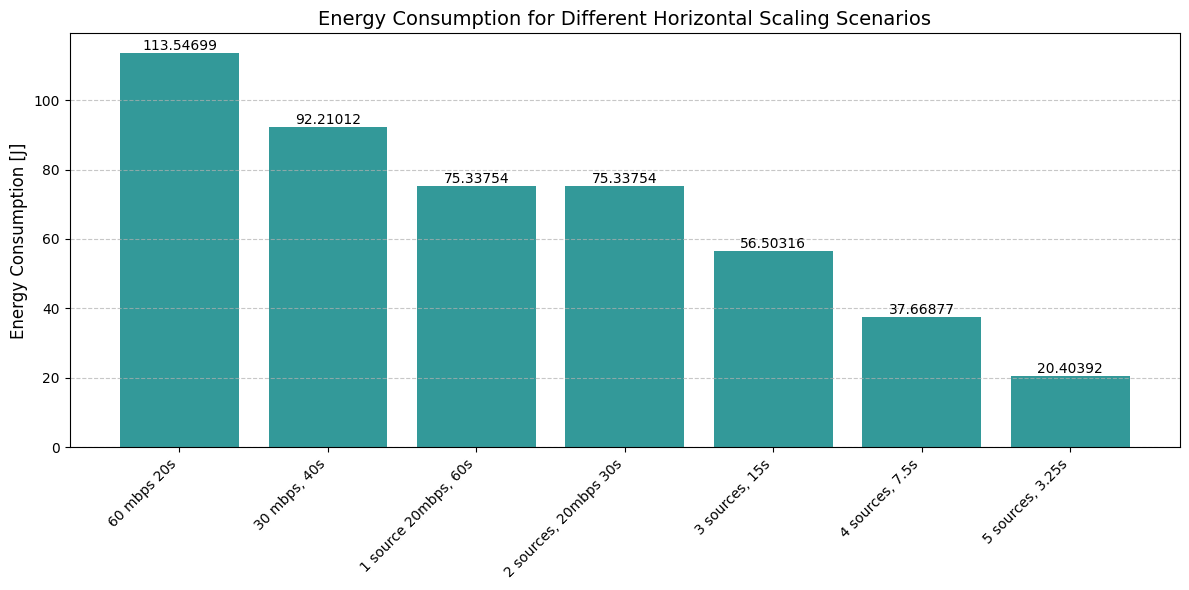

In [53]:
# Assuming per_throughput_stats is your DataFrame containing the relevant MultiIndex data
# Filter and calculate total energy consumption for each deployment scenario
# Define the energy columns you need

# Deployment scenario 1: One source at 20Mbps, working for 60 seconds
deployment_upper_limit = per_throughput_stats[per_throughput_stats['Mbps requested'] == 20]
# Define the baseline energy per source for 20Mbps for 60 seconds
base_energy_per_source = deployment_upper_limit[('total energy service [J]', 'mean')].iloc[0]

dep_60mbps_20s=per_throughput_stats[per_throughput_stats['Mbps requested'] == 60]
dep_60mbps_20s=dep_60mbps_20s[('total energy service [J]', 'mean')].iloc[0]

dep_30mbps_40s=per_throughput_stats[per_throughput_stats['Mbps requested'] == 30]
dep_30mbps_40s=dep_30mbps_40s[('total energy service [J]', 'mean')].iloc[0]

# Define scenarios for horizontal scaling
scenarios = {
    '60 mbps 20s': dep_60mbps_20s,
    '30 mbps, 40s': dep_30mbps_40s,
    '1 source 20mbps, 60s': 1 * base_energy_per_source,
    '2 sources, 20mbps 30s': 2 * base_energy_per_source * (30 / 60),
    '3 sources, 15s': 3 * base_energy_per_source * (15 / 60),
    '4 sources, 7.5s': 4 * base_energy_per_source * (7.5 / 60),
    '5 sources, 3.25s': 5 * base_energy_per_source * (3.25 / 60),
}

# Prepare data for the plot
scenario_names = list(scenarios.keys())
scenario_energies = list(scenarios.values())

# Plot the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(scenario_names, scenario_energies, color='teal', alpha=0.8)

# Add values on top of the bars
for bar, energy in zip(bars, scenario_energies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{energy:.5f}',  # Display the energy value
        ha='center',
        va='bottom',
        fontsize=10
    )

# Add labels and title
plt.ylabel('Energy Consumption [J]', fontsize=12)
plt.title('Energy Consumption for Different Horizontal Scaling Scenarios', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
